In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('paper')

## Ultimate Challenge Pt 1

In [2]:
# need a column besides login_time to do a groupby operation to count logins in 15 minute intervals on login time

logins = pd.read_json('./logins.json')
logins['count'] = 1

In [3]:
# the data is not already sorted by login_time. doesn't matter since we're grouping the values, but is a quality issue 
# of the underlying data table

logins = logins.sort_values('login_time')

In [4]:
logins_counts = logins.groupby(pd.Grouper(key='login_time',freq='15min')).count()
logins_counts.reset_index(inplace=True)

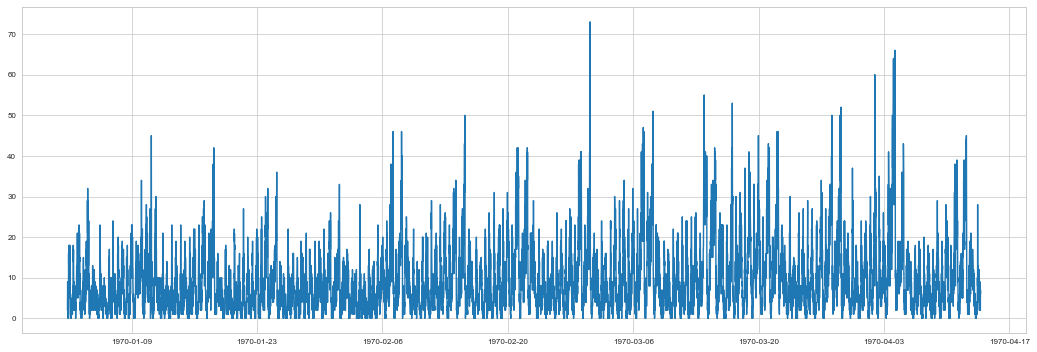

In [5]:
# here is the entire dataset of logins. the visualization at this point is not entirely clear, but it seems that there 
# are some repetitive patterns/cycles

fig, ax = plt.subplots(1,1,figsize=(18,6))

ax.plot(logins_counts['login_time'],logins_counts['count'])

In [6]:
first_day = logins_counts[(logins_counts.login_time >= np.datetime64('1970-01-02 00:00:00')) & \
                          (logins_counts.login_time < np.datetime64('1970-01-03 00:00:00'))].copy()

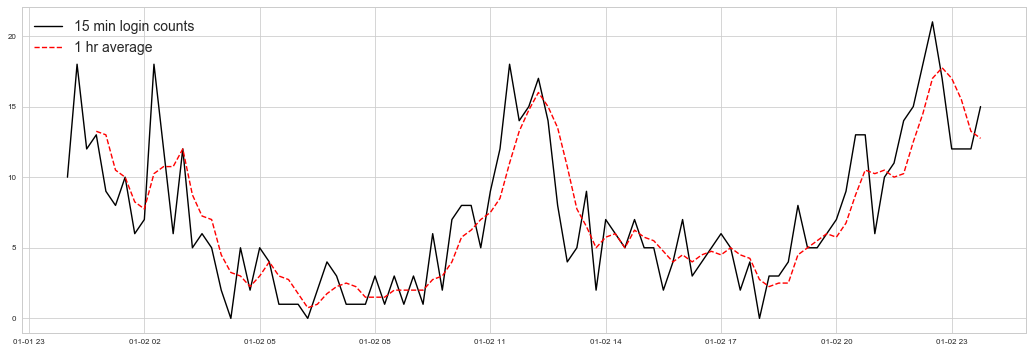

In [7]:
# the first full day available in the dataset, beginning at the first midnight. first look at what types of cycles
# a typical day may contain. must explore deeper to look for weekly/monthly patterns

fig, ax = plt.subplots(1,1,figsize=(18,6))

ax.plot(first_day['login_time'],first_day['count'],'k')
ax.plot(first_day['login_time'],first_day['count'].rolling(window=4).mean(),'r--')
ax.legend(['15 min login counts','1 hr average'],fontsize=14)

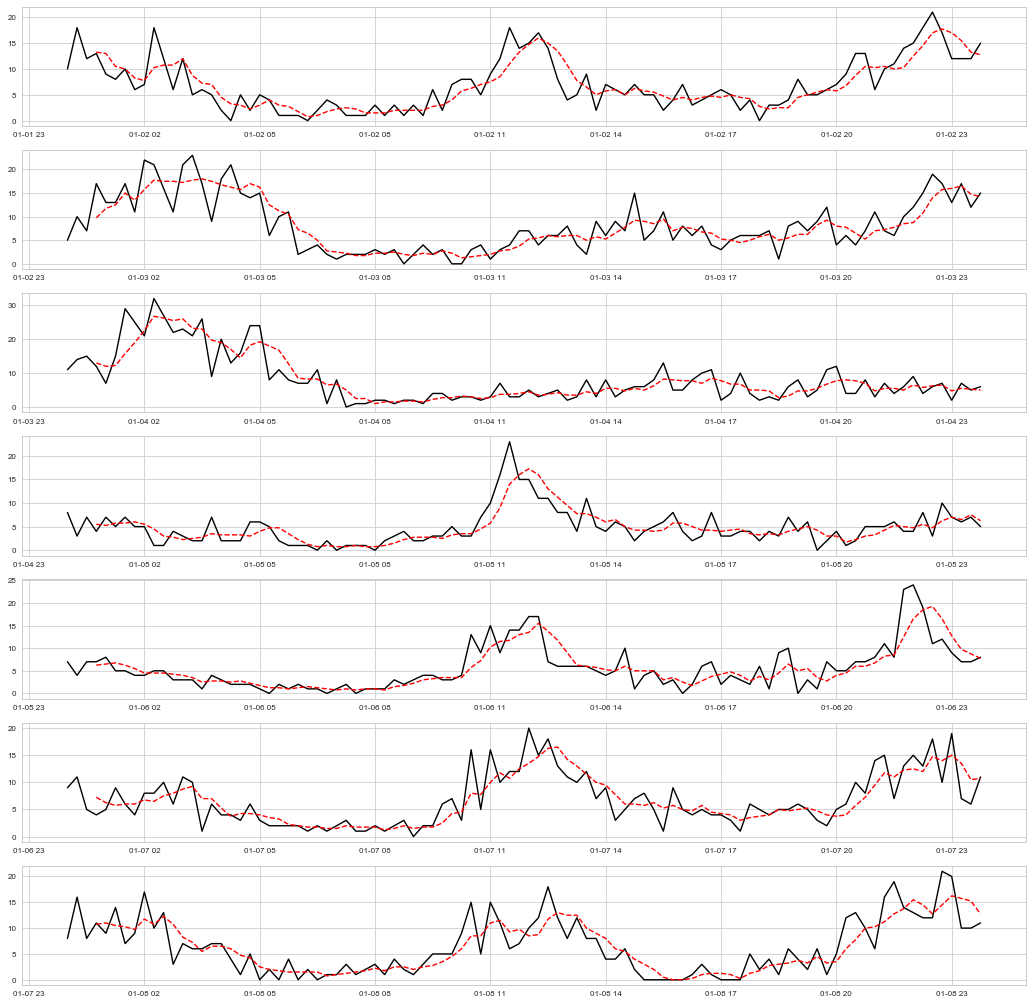

In [8]:
# the first full week, starting on the first midnight. 
# jan 2, 1970 was a friday. fri/sat/sun pattern look distinctly different from mon-thur. almost inverted?

fig = plt.figure(figsize=(18,18))

for i in range(7):
    day = logins_counts[(logins_counts.login_time >= (np.datetime64('1970-01-02 00:00:00')+np.timedelta64(i,'D'))) & \
                        (logins_counts.login_time < (np.datetime64('1970-01-02 00:00:00')+np.timedelta64(i+1,'D')))].copy()
    
    ax = fig.add_subplot(7,1,i+1)
    ax.plot(day['login_time'],day['count'],'k')
    ax.plot(day['login_time'],day['count'].rolling(window=4).mean(),'r--')

In [9]:
# first/last day have incomplete data.. leave those out

daily_counts = logins_counts.groupby(pd.Grouper(key='login_time',freq='1D')).sum()[1:-1].copy()

In [10]:
from sklearn.cluster import KMeans

Text(0.5,1,'Error Measured by Total Sum of Squares')

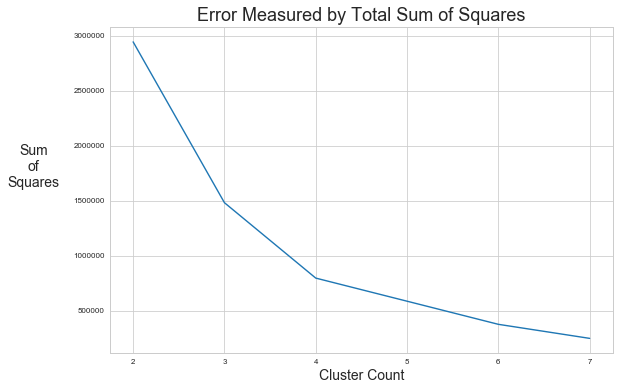

In [11]:
# error analysis suggests using about 4 clusters. we will do three clusterings: one with 2, one with 4, and one with 7
# 2 groups to differentiate between work days and non-work days
# (we know that there are 7 days of the week..7 clusters makes intuitive sense. the hope with this approach is that
# holidays will be assigned to a group of the normal Mon-Sun categories)

kvalues = list(range(2,8))
ss = []

for k in kvalues:
    kmeans = KMeans(n_clusters=k).fit(daily_counts.reset_index()['count'].values.reshape(-1,1))
    ss.append(kmeans.inertia_)
    
f, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(kvalues,ss)
ax.set_ylabel('Sum\nof\nSquares',fontsize=14,rotation=0,labelpad=40)
ax.set_xlabel('Cluster Count',fontsize=14)
ax.set_title('Error Measured by Total Sum of Squares',fontsize=18)

In [12]:
kmeans4 = KMeans(n_clusters=4,random_state=10).fit(daily_counts.reset_index()['count'].values.reshape(-1,1))
kmeans7 = KMeans(n_clusters=7,random_state=10).fit(daily_counts.reset_index()['count'].values.reshape(-1,1))

In [13]:
daily_counts.reset_index(inplace=True)

In [14]:
daily_counts['cluster4'] = kmeans4.labels_
daily_counts['cluster7'] = kmeans7.labels_

In [15]:
# this 1-D approach seems to find some groupings between weekdays and weekends, but is probably not too good..
# taking sums of daily login counts to differentiate days may not be enough to find distinct separations in days

daily_counts.head(10)

,login_time,count,cluster4,cluster7
0,1970-01-02,681,3,4
1,1970-01-03,793,0,0
2,1970-01-04,788,0,0
3,1970-01-05,459,3,5
4,1970-01-06,536,3,5
5,1970-01-07,648,3,4
6,1970-01-08,625,3,4
7,1970-01-09,881,0,0
8,1970-01-10,1054,2,2
9,1970-01-11,1014,2,2


In [16]:
# instead, break up each day into four 6-hour intervals and take the sum of login counts in each interval as a new dimension
# thus, we can run K-Means with a richer feature space (login counts during different times of the day)

In [17]:
# since the aggregated dataframe contains only 407 datapoints, we can use a brute force method. would need to use
# a more clever (efficient) vectorized approach for bigger data sets

# we could repeat this process for even 'finer' time windows. would be a bit more computationally expensive, but the
# algorithm would probably find very good clusterings

q1 = []
q2 = []
q3 = []
q4 = []

for i in range(0,404,4):
    
    q1.append(logins_counts.groupby(pd.Grouper(key='login_time',freq='6H')).sum()[1:-1].reset_index().loc[i,'count'])
    q2.append(logins_counts.groupby(pd.Grouper(key='login_time',freq='6H')).sum()[1:-1].reset_index().loc[i+1,'count'])
    q3.append(logins_counts.groupby(pd.Grouper(key='login_time',freq='6H')).sum()[1:-1].reset_index().loc[i+2,'count'])
    q4.append(logins_counts.groupby(pd.Grouper(key='login_time',freq='6H')).sum()[1:-1].reset_index().loc[i+3,'count'])

# data seems to have aligned correctly. (checked beginning and end)

daily_counts['q1'] = q1
daily_counts['q2'] = q2
daily_counts['q3'] = q3
daily_counts['q4'] = q4

In [18]:
# we can repeat a similar process to measure the standard deviation over these 6-hour intervals, thus incorporating
# information about volatility of demand into the clusterings. 

Q1 = []
Q2 = []
Q3 = []
Q4 = []

for i in range(0,404,4):
    
    Q1.append(logins_counts.groupby(pd.Grouper(key='login_time',freq='6H')).std()[1:-1].reset_index().loc[i,'count'])
    Q2.append(logins_counts.groupby(pd.Grouper(key='login_time',freq='6H')).std()[1:-1].reset_index().loc[i+1,'count'])
    Q3.append(logins_counts.groupby(pd.Grouper(key='login_time',freq='6H')).std()[1:-1].reset_index().loc[i+2,'count'])
    Q4.append(logins_counts.groupby(pd.Grouper(key='login_time',freq='6H')).std()[1:-1].reset_index().loc[i+3,'count'])
    
daily_counts['Q1'] = Q1
daily_counts['Q2'] = Q2
daily_counts['Q3'] = Q3
daily_counts['Q4'] = Q4

In [19]:
# we could include all the columns...but we leave the input as the four daily quarters for simplicity/interpretability

kmeans4a = KMeans(n_clusters=4,random_state=10).fit(daily_counts.reset_index()[['q1','q2','q3','q4','Q1','Q2','Q3','Q4']])
kmeans7a = KMeans(n_clusters=7,random_state=10).fit(daily_counts.reset_index()[['q1','q2','q3','q4','Q1','Q2','Q3','Q4']])

In [20]:
daily_counts['cluster4a'] = kmeans4a.labels_
daily_counts['cluster7a'] = kmeans7a.labels_

In [21]:
# this clustering probably does a much better job separating days based on the underlying patterns of demand
# remember: jan 2, 1970 was a friday. 
# weekday behavior seems to be too similar for the clustering to find distinct patterns between mon, ... , fri
# and weekend behavior seems to be too similar for the clustering to find distinct patterns between sat and sun

# all of january, days are grouped into 0 or 1 on cluster4a. it's not until later months that behavior changes enough
# to be classified into other clusters. 

daily_counts[['login_time','cluster4a','cluster7a']].head()

,login_time,cluster4a,cluster7a
0,1970-01-02,1,5
1,1970-01-03,0,3
2,1970-01-04,0,3
3,1970-01-05,1,0
4,1970-01-06,1,0


In [22]:
# we study the groupings made with n_clusters = 4 in KMeans w/ 8 input features (the quarterly daily login counts and SDs)

cluster_means = []
cluster_SDs = []

for i in range(4):
    cluster_means.append(daily_counts[daily_counts.cluster4a==i].describe()['count'].loc['mean'])
    cluster_SDs.append(daily_counts[daily_counts.cluster4a==i].describe()['count'].loc['std'])

In [23]:
# days belonging to cluster 1 have the most distinct cluster mean: 660.8 (significantly smaller average login count)
# we explore this cluster first, and then explore the others against it

print(cluster_means)
print(cluster_SDs)

[1008.3125, 660.84905660377353, 1103.0625, 1489.25]
[155.78006665381378, 118.90273921707461, 182.88957278459955, 160.09393076149598]


In [24]:
cluster1 = logins_counts[pd.to_datetime(logins_counts.login_time.astype(str).apply(lambda x: x[:-9]))\
                        .isin(daily_counts[daily_counts.cluster4a==1].login_time)].copy()
cluster1 = cluster1.reset_index().drop('index',axis=1)

In [25]:
cluster0 = logins_counts[pd.to_datetime(logins_counts.login_time.astype(str).apply(lambda x: x[:-9]))\
                        .isin(daily_counts[daily_counts.cluster4a==0].login_time)].copy()
cluster0 = cluster0.reset_index().drop('index',axis=1)

cluster2 = logins_counts[pd.to_datetime(logins_counts.login_time.astype(str).apply(lambda x: x[:-9]))\
                        .isin(daily_counts[daily_counts.cluster4a==2].login_time)].copy()
cluster2 = cluster2.reset_index().drop('index',axis=1)

cluster3 = logins_counts[pd.to_datetime(logins_counts.login_time.astype(str).apply(lambda x: x[:-9]))\
                        .isin(daily_counts[daily_counts.cluster4a==3].login_time)].copy()
cluster3 = cluster3.reset_index().drop('index',axis=1)

In [26]:
# clusters 0, 2, 3 have the same exact number of datapoints..very weird coincidence (probably not a coincidence..)

# cluster 1 is definitely the most common.. "typical weekday" ?

print(len(cluster0))
print(len(cluster1))
print(len(cluster2))
print(len(cluster3))

1536
5088
1536
1536


In [27]:
# we will group by the time of day within cluster 1, with the mean as the agg func, to plot the average login counts
# during different times of days in cluster 1

cluster1.login_time = cluster1.login_time.astype(str).apply(lambda x: x[11:])

In [28]:
# do the same for the others

cluster0.login_time = cluster0.login_time.astype(str).apply(lambda x: x[11:])
cluster2.login_time = cluster2.login_time.astype(str).apply(lambda x: x[11:])
cluster3.login_time = cluster3.login_time.astype(str).apply(lambda x: x[11:])

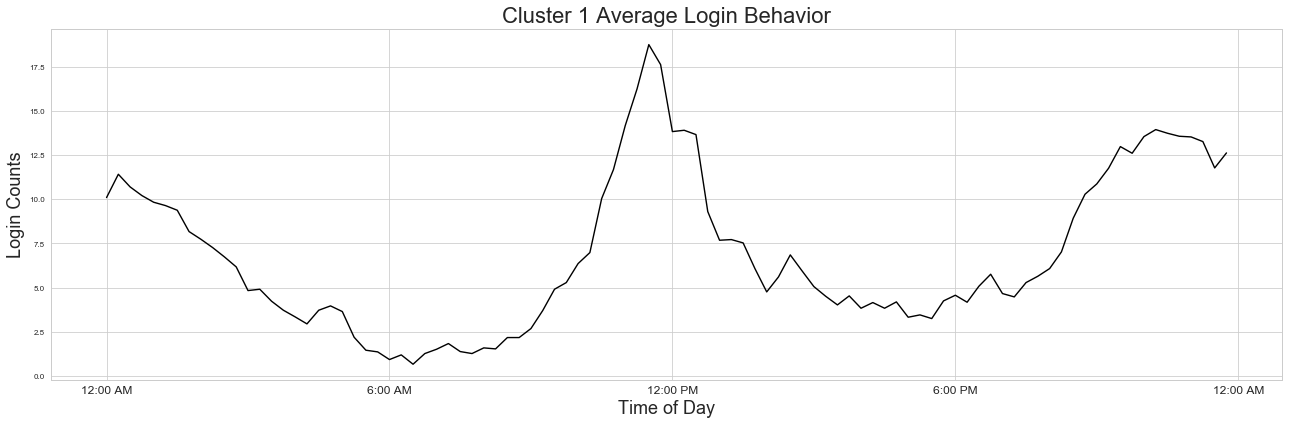

In [29]:
# this is about half the days in the dataset. typical 'weekday behavior'
# we see the most of cluster 1, so this will be our "baseline behavior" to compare against

fig, ax = plt.subplots(1,1,figsize=(18,6))

ax.plot(cluster1.groupby('login_time').mean().index,cluster1.groupby('login_time').mean()['count'],'k')
ax.set_xticks(ticks=[0,24,48,72,96])
ax.set_xticklabels(['12:00 AM','6:00 AM','12:00 PM','6:00 PM','12:00 AM'],fontsize=12)
ax.set_ylabel('Login Counts',fontsize=18)
ax.set_xlabel('Time of Day',fontsize=18)
ax.set_title('Cluster 1 Average Login Behavior',fontsize=22)

plt.tight_layout()

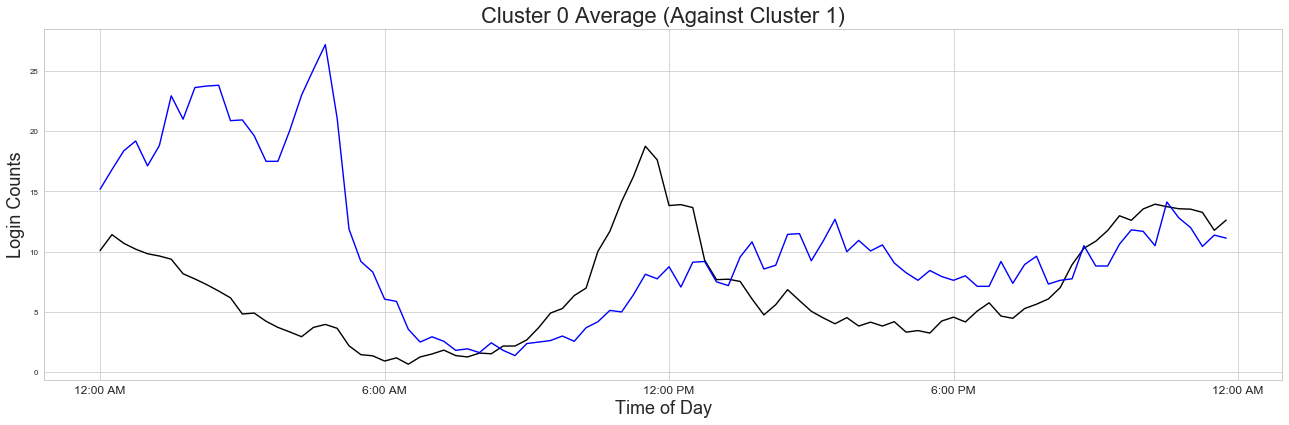

In [30]:
# Cluster 0 seems to have very distinct behavior on average. much more login counts during odd hours of the day
# (i.e. early morning: midnight - 5 AM) and fewer login counts during normal daytime

fig, ax = plt.subplots(1,1,figsize=(18,6))

ax.plot(cluster1.groupby('login_time').mean().index,cluster1.groupby('login_time').mean()['count'],'k')
ax.plot(cluster0.groupby('login_time').mean().index,cluster0.groupby('login_time').mean()['count'],'b')
ax.set_xticks(ticks=[0,24,48,72,96])
ax.set_xticklabels(['12:00 AM','6:00 AM','12:00 PM','6:00 PM','12:00 AM'],fontsize=12)
ax.set_ylabel('Login Counts',fontsize=18)
ax.set_xlabel('Time of Day',fontsize=18)
ax.set_title('Cluster 0 Average (Against Cluster 1)',fontsize=22)

plt.tight_layout()

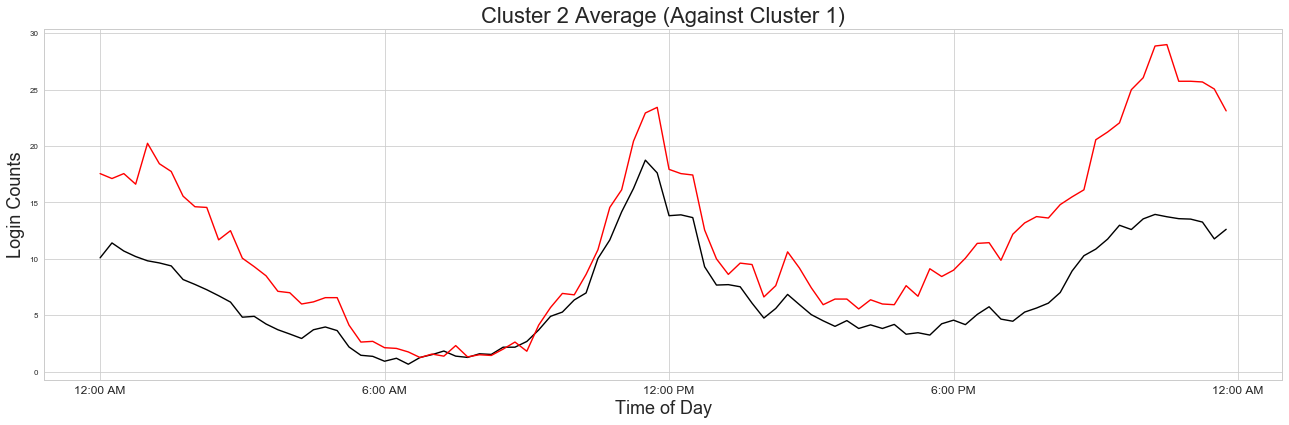

In [31]:
# cluster 2: the average behavior looks very similar to that of cluster 0, but with a general increase in login count
# throughout the day

fig, ax = plt.subplots(1,1,figsize=(18,6))

ax.plot(cluster1.groupby('login_time').mean().index,cluster1.groupby('login_time').mean()['count'],'k')
ax.plot(cluster2.groupby('login_time').mean().index,cluster2.groupby('login_time').mean()['count'],'r')
ax.set_xticks(ticks=[0,24,48,72,96])
ax.set_xticklabels(['12:00 AM','6:00 AM','12:00 PM','6:00 PM','12:00 AM'],fontsize=12)
ax.set_ylabel('Login Counts',fontsize=18)
ax.set_xlabel('Time of Day',fontsize=18)
ax.set_title('Cluster 2 Average (Against Cluster 1)',fontsize=22)

plt.tight_layout()

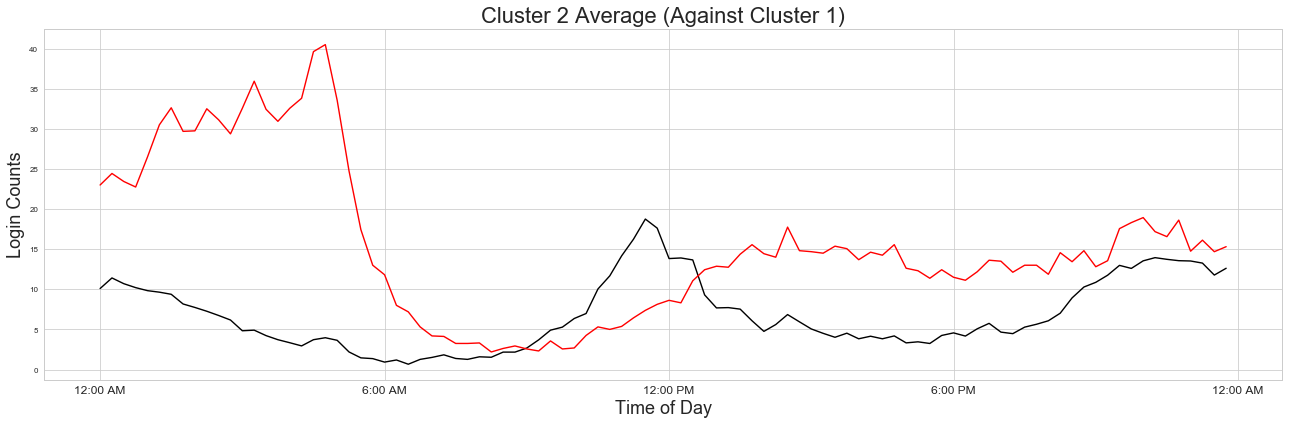

In [32]:
# the average behavior looks very similar to that of cluster 0.

fig, ax = plt.subplots(1,1,figsize=(18,6))

ax.plot(cluster1.groupby('login_time').mean().index,cluster1.groupby('login_time').mean()['count'],'k')
ax.plot(cluster3.groupby('login_time').mean().index,cluster3.groupby('login_time').mean()['count'],'r')
ax.set_xticks(ticks=[0,24,48,72,96])
ax.set_xticklabels(['12:00 AM','6:00 AM','12:00 PM','6:00 PM','12:00 AM'],fontsize=12)
ax.set_ylabel('Login Counts',fontsize=18)
ax.set_xlabel('Time of Day',fontsize=18)
ax.set_title('Cluster 2 Average (Against Cluster 1)',fontsize=22)

plt.tight_layout()

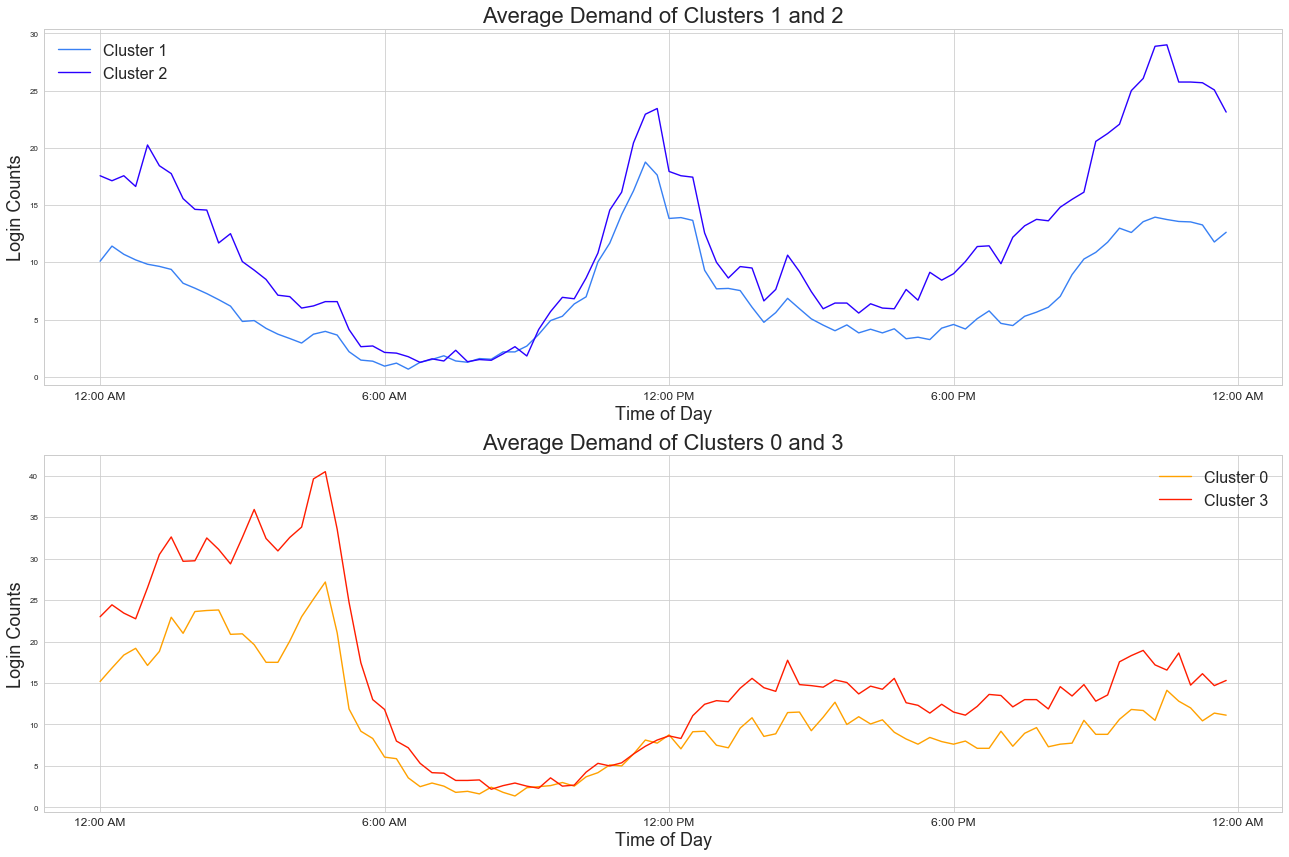

In [33]:
# it seems more appropriate (using visual analysis) to divide days into two categories, instead of 4 as suggested by the
# reduction in sum of squares when using KMeans. (ps this shows the lack of robustness/reliability of the elbow method)

# we could re-run this whole process and return 2 time series that look approximately like the averages of each 
# respective set of 2 clusters below

# for predicting future login counts, it seems a matter of first categorizing the day (cluster 1/2 or 0/3 ?) based on
# context-based knowledge (in this case, clusters 1/2 probably correspond to normal weekdays, while clusters 0/3 
# probably correspond to weekends/holidays) and using the averages below for a general idea of expected behavior
# during different times of the day. for further specificity, we could break up the original dataset into monthly
# periods and use the month/season as an additional input to groupby and measure average user behavior

# note that we found this "higher level clustering" via visual analysis, but we could apply another clustering algorithm
# to these cluster averages to find these two categories in a more technical/automated approach. i.e. the alg would
# put clusters 1 and 2 into a single cluster, and cluster 0 and 3 into a single cluster.

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(18,12))

ax1.plot(cluster1.groupby('login_time').mean().index,cluster1.groupby('login_time').mean()['count'],'#3880f4')
ax1.plot(cluster2.groupby('login_time').mean().index,cluster2.groupby('login_time').mean()['count'],'#2a00ff')
ax1.set_xticks(ticks=[0,24,48,72,96])
ax1.set_xticklabels(['12:00 AM','6:00 AM','12:00 PM','6:00 PM','12:00 AM'],fontsize=12)
ax1.set_ylabel('Login Counts',fontsize=18)
ax1.set_xlabel('Time of Day',fontsize=18)
ax1.set_title('Average Demand of Clusters 1 and 2',fontsize=22)
ax1.legend(['Cluster 1','Cluster 2'],fontsize=16)

ax2.plot(cluster0.groupby('login_time').mean().index,cluster0.groupby('login_time').mean()['count'],'#ffa100')
ax2.plot(cluster3.groupby('login_time').mean().index,cluster3.groupby('login_time').mean()['count'],'#ff1d00')
ax2.set_xticks(ticks=[0,24,48,72,96])
ax2.set_xticklabels(['12:00 AM','6:00 AM','12:00 PM','6:00 PM','12:00 AM'],fontsize=12)
ax2.set_ylabel('Login Counts',fontsize=18)
ax2.set_xlabel('Time of Day',fontsize=18)
ax2.set_title('Average Demand of Clusters 0 and 3',fontsize=22)
ax2.legend(['Cluster 0','Cluster 3'],fontsize=16)

plt.tight_layout()

In [34]:
# the dataset spans about 3 months and 10 days. our clustering algorithm finds the first instances of clusters 2 and 3
# a few days into the second month, suggesting that the underlying demand changes enough during that time for the alg
# to find different clusters. 

# in particular, by studying the graphs above we can see that, overall on average, demand increases by the second month. 
# (the darker curves, representing clusters 2 and 3, both lie above the lighter curves, which represent clusters 0 and 1)

print('first day: '+str(daily_counts.login_time.min()))
print('last day: '+str(daily_counts.login_time.max()))
print('')
print(str(daily_counts[daily_counts.cluster4a==0].login_time.min()))
print(str(daily_counts[daily_counts.cluster4a==1].login_time.min()))
print(str(daily_counts[daily_counts.cluster4a==2].login_time.min()))
print(str(daily_counts[daily_counts.cluster4a==3].login_time.min()))

first day: 1970-01-02 00:00:00
last day: 1970-04-12 00:00:00

1970-01-03 00:00:00
1970-01-02 00:00:00
1970-02-06 00:00:00
1970-02-08 00:00:00


In [35]:
# the "macro-change" in demand is not definite, however. there are instances of clusters 0 and 1 into the last few days

print(str(daily_counts[daily_counts.cluster4a==0].login_time.max()))
print(str(daily_counts[daily_counts.cluster4a==1].login_time.max()))
print(str(daily_counts[daily_counts.cluster4a==2].login_time.max()))
print(str(daily_counts[daily_counts.cluster4a==3].login_time.max()))

1970-04-05 00:00:00
1970-04-09 00:00:00
1970-04-10 00:00:00
1970-04-12 00:00:00


In [36]:
print(len(daily_counts[daily_counts.cluster4a==0]))
print(len(daily_counts[daily_counts.cluster4a==1]))
print(len(daily_counts[daily_counts.cluster4a==2]))
print(len(daily_counts[daily_counts.cluster4a==3]))

16
53
16
16


In [37]:
avgdifference1 = cluster2.groupby('login_time').mean()['count']-cluster1.groupby('login_time').mean()['count']
avgdifference2 = cluster3.groupby('login_time').mean()['count']-cluster0.groupby('login_time').mean()['count']

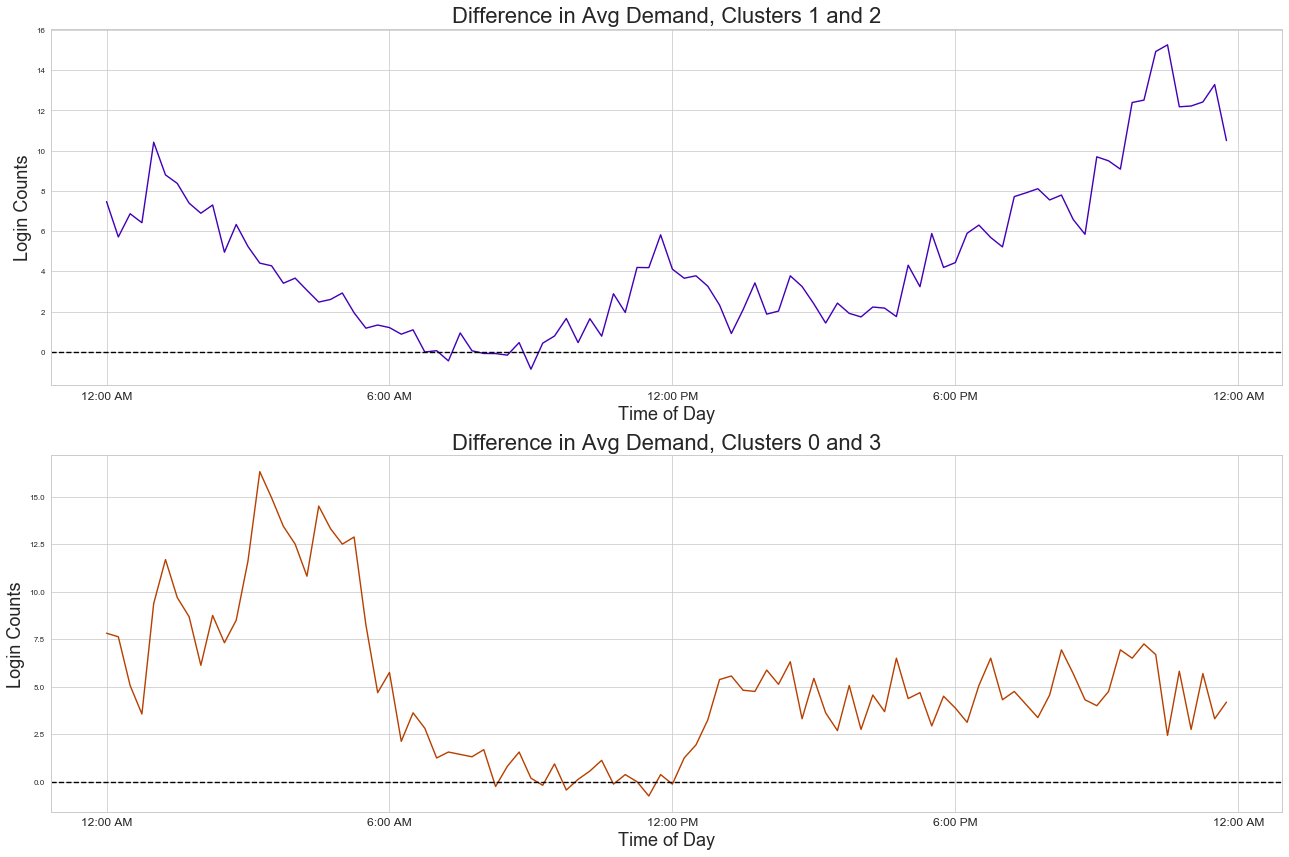

In [38]:
# below we have the difference in each respective set of 2 clusters. we see that (on average) clusters 2 and 3 had more
# login counts than clusters 0 and 1. this is especially true during "peak demand" hours -- 12 am - 6 am and 12 pm - 12 am
# around 6 am - 12 pm, the behavior of demand is about the same as in clusters 0 and 1 (the difference curves are close
# to 0, the dotted horizontal line)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(18,12))

ax1.plot(avgdifference1.index,avgdifference1,'#4300b7')
ax1.set_xticks(ticks=[0,24,48,72,96])
ax1.set_xticklabels(['12:00 AM','6:00 AM','12:00 PM','6:00 PM','12:00 AM'],fontsize=12)
ax1.set_ylabel('Login Counts',fontsize=18)
ax1.set_xlabel('Time of Day',fontsize=18)
ax1.set_title('Difference in Avg Demand, Clusters 1 and 2',fontsize=22)
ax1.axhline(color='k',linestyle='--')

ax2.plot(avgdifference2.index,avgdifference2,'#b74000')
ax2.set_xticks(ticks=[0,24,48,72,96])
ax2.set_xticklabels(['12:00 AM','6:00 AM','12:00 PM','6:00 PM','12:00 AM'],fontsize=12)
ax2.set_ylabel('Login Counts',fontsize=18)
ax2.set_xlabel('Time of Day',fontsize=18)
ax2.set_title('Difference in Avg Demand, Clusters 0 and 3',fontsize=22)
ax2.axhline(color='k',linestyle='--')

plt.tight_layout()

In [39]:
# we set weekdays based on the knowledge that the first day in the dataset is a friday

days = ['F','SA','SU','M','T','W','R']

while len(days) < (len(daily_counts.login_time)+7):
    days = days + days
    
days = days[:len(daily_counts.login_time)]
daily_counts['day'] = days

In [40]:
# cluster 0 seems to correspond to weekend behavior, with 1 thursday and 1 tuesday sneaking in there... unusual behavior

daily_counts[daily_counts.cluster4a==0].day.value_counts()

SA    7
SU    7
T     1
R     1
Name: day, dtype: int64

In [41]:
# no weekends. cluster 1 definitely corresponds to typical weekday behavior

daily_counts[daily_counts.cluster4a==1].day.value_counts()

M    14
T    13
W    11
R    10
F     5
Name: day, dtype: int64

In [42]:
# special subset of weekdays?

daily_counts[daily_counts.cluster4a==2].day.value_counts()

F    10
R     3
W     3
Name: day, dtype: int64

In [43]:
# more weekend behavior, as we predicted in the visual analysis

daily_counts[daily_counts.cluster4a==3].day.value_counts()

SU    8
SA    8
Name: day, dtype: int64

In conclusion, it seems that there are two 'main patterns of demand' which depend on the particular day on a micro-scale (in the case of 4 clusters, they are 1 & 2 and 0 & 3). However, there is also a trend in demand that occurs over the long term macro-scale, which can be observed in the slight changes in the patterns of demand within each 'main pattern of demand' (i.e. the overall increase in cluster 2 over 1, and cluster 3 over 0).

Note, we can repeat this analysis with more clusters to look for more evidence of macro-scale trends in demand, but we would require more data for that to actually be illustrative.. Applying that approach to this dataset would most likely not help our understanding any further and will not be explored.

In [96]:
# ASIDE. a more simple approach to investigating daily/weekly patterns: develop the weekday columns FIRST, and then
# use a simple groupby() call to look at changes in characteristics over different timelines: weekdays, weekends, months, etc.

# also: the clustering we did in the cells above ended up finding the distinct patterns between weekdays/weekends. (with the
# odd exception of cluster 0--which certainly has its own explanation.) below, we reverse the approach. begin with the 
# weekdays and study the characteristics. 

In [104]:
# q - average count
# Q - standard deviation of the count
# what's being return below, however, is the mean of these quantties ^ over the data set

# interesting: there is a steady increase in average count as the days progress from Mon to Sat
# Sun is a bit of an anomaly. makes sense -- people are less active/are preparing for the start of the next week 

daily_counts.groupby('day').mean()[['count','q1','q2','q3','q4','Q1','Q2','Q3','Q4']].sort_values('count')

,count,q1,q2,q3,q4,Q1,Q2,Q3,Q4
day,,,,,,,,,
M,602.000000,122.214286,140.714286,151.000000,188.071429,3.326919,6.148983,4.201704,4.012643
T,662.000000,144.785714,138.142857,144.928571,234.142857,4.429989,6.759887,4.218261,5.189342
W,738.500000,181.000000,145.428571,153.142857,258.928571,4.855531,7.211653,4.263985,6.185793
R,846.285714,213.142857,154.928571,175.000000,303.214286,5.638176,7.350862,4.733853,6.327999
F,1013.866667,253.533333,141.400000,214.866667,404.066667,6.148275,6.312301,4.476401,7.768678
SU,1211.133333,596.133333,93.933333,283.333333,237.733333,9.384761,2.728760,4.528985,3.572401
SA,1291.800000,587.333333,93.800000,272.933333,337.733333,7.867188,3.253026,4.132534,5.568989


## Pt 2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

In [44]:
# ultimately, we want to see some significant change in behavior (towards a trend we're aiming for) of the drivers.
# as done in pt 1, we would first establish what is the current typical behavior ('baseline') during different times of
# day of drivers, as well as establish what is the future behavior we are aiming to achieve. (we would have to establish
# a current baseline and a future target twice -- once for each city)

# then, with an approach akin to A/B testing, we apply whatever subsidies/incentives for drivers to alter their behavior
# towards our desired targets, and observe the changes over enough samples to measure for statistical significance of
# changes in behavior. (of course, this is all assuming the infrastructure is in place to measure driver behavior
# and collect data. i.e. unique driver IDs, as well as counters for each pass-through of the toll bridge and resultant work
# activity of the drivers)

# in the context of this question, the metric would seem to be quantity of pass-throughs on the toll bridge followed by
# the desired driver activity. (we don't simply want to increase toll pass-throughs..we want the drivers to be passing
# through to work--drive--in the city). again, assuming the infrastructure is in place to track driver activity,
# we can isolate and measure the changes in drivers' work activity in the opposing cities that we are aiming for

# interpretation of the results will all have to be done relative to the baselines established (as in pt 1) and the hypothesis
# tests conducting within A/B testing before and after the changes/incentives have been put in place

# the entire process will consume resources and time without any guarantee of success. this is an experiment after all, and
# the least we can expect is knowledge of whether a technique will or will not produce the desired effect. we can also
# attempt to interpret the results of our tests as best as possible, but there is no guarantee that our interpretation
# will be 100% correct, or that we will be able to adjust our techniques to better optimize for our goals. as with all
# statistical analysis, there will be a degree of confidence, as well as some ambiguity for causation/correlation
# of our results. it is important that we are optimizing for the correct metrics (increased pass-through of toll bridge,
# followed by work activity, during desired times) or else we will find seemingly (statistically) significant results which
# have little business-domain significance. in this case, the experiment wouldn't prove to be much more than a statistical
# study. i.e. the entire experiment must be carefully designed to isolate causes/effects as best as possible

## Pt 3

### Q1

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [45]:
import json

In [46]:
with open('./ultimate_data_challenge.json') as f:
    data = json.load(f)
    
user_info = pd.DataFrame(data)

In [47]:
user_info.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [48]:
# "Retained" if the user took a trip in the preceding 30 days..but we don't know when "today" is, to define "preceding"
# assume it's the max of 'last_trip_date'

user_info.last_trip_date = pd.to_datetime(user_info.last_trip_date)
user_info.signup_date = pd.to_datetime(user_info.signup_date)
user_info.last_trip_date.max()
user_info1 = user_info.copy()

In [49]:
# create new column in original table instead of separating into retained and non-retained tables
# use the assumption in the cell block above to determine if users were retained

user_info['retained'] = (user_info.last_trip_date>=(user_info.last_trip_date.max()-np.timedelta64(30,'D'))).astype(int)

In [50]:
user_info.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [51]:
# retained user summary. about twice as many trips in the first 30 days as non-retained users. most other 
# metrics look just about equal (on average), with exception of avg distance of trip. retained users took shorter 
# trips on average (perhaps suggesting that they used the service for everyday usage, while non-retained users
# used the service for a "one-time" need to travel far)

user_info[user_info.retained.astype(bool)].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained
count,18804.000000,18768.000000,17172.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.0
mean,5.114788,4.762772,4.592930,1.073809,9.152797,3.306318,61.389034,1.0
std,4.615175,0.328489,0.542386,0.163170,15.588704,4.986743,29.487584,0.0
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
25%,2.560000,4.700000,4.300000,1.000000,0.000000,0.000000,44.400000,1.0
50%,3.730000,4.800000,4.800000,1.000000,0.000000,2.000000,64.300000,1.0
75%,5.890000,5.000000,5.000000,1.090000,13.300000,4.000000,84.600000,1.0
max,160.960000,5.000000,5.000000,4.500000,100.000000,125.000000,100.000000,1.0


In [52]:
# non-retained user summary. 

user_info[~user_info.retained.astype(bool)].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained
count,31196.000000,31031.000000,24706.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.0
mean,6.207939,4.787464,4.607557,1.075339,8.666739,1.658482,60.647032,0.0
std,6.238675,0.504648,0.664418,0.251361,22.179139,2.654222,40.982688,0.0
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0
25%,2.320000,4.800000,4.400000,1.000000,0.000000,0.000000,16.700000,0.0
50%,4.030000,5.000000,5.000000,1.000000,0.000000,1.000000,69.600000,0.0
75%,7.800000,5.000000,5.000000,1.000000,0.000000,2.000000,100.000000,0.0
max,129.890000,5.000000,5.000000,8.000000,100.000000,73.000000,100.000000,0.0


In [53]:
# about 38% of users are retained overall

print(len(user_info[user_info.retained.astype(bool)])/len(user_info))

0.37608


### Q2

2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

In [54]:
# some missing values to deal with before building predictive models.  we will leave the phone category with NaNs.
# cannot reasonably predict what type of phone the users have

user_info.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
retained                     0
dtype: int64

In [55]:
# to fill the missing values, we will use the averages when grouped by the retained/nonretained users

avgs = user_info.groupby('retained').mean()[['avg_rating_by_driver','avg_rating_of_driver']]
avgs

,avg_rating_by_driver,avg_rating_of_driver
retained,,
0,4.787464,4.607557
1,4.762772,4.592930


In [56]:
# filling values of retained users w/ averages

user_info.loc[user_info[(user_info.retained.astype(bool)) & (user_info.avg_rating_by_driver.isnull())].index,'avg_rating_by_driver'] = \
    avgs.loc[1,'avg_rating_by_driver']
    
user_info.loc[user_info[(user_info.retained.astype(bool)) & (user_info.avg_rating_of_driver.isnull())].index,'avg_rating_of_driver'] = \
    avgs.loc[1,'avg_rating_of_driver']

In [57]:
# filling values of non-retained users w/ averages

user_info.loc[user_info[(~user_info.retained.astype(bool)) & (user_info.avg_rating_by_driver.isnull())].index,'avg_rating_by_driver'] = \
    avgs.loc[0,'avg_rating_by_driver']
    
user_info.loc[user_info[(~user_info.retained.astype(bool)) & (user_info.avg_rating_of_driver.isnull())].index,'avg_rating_of_driver'] = \
    avgs.loc[0,'avg_rating_of_driver']

In [58]:
user_info.isnull().sum()

avg_dist                    0
avg_rating_by_driver        0
avg_rating_of_driver        0
avg_surge                   0
city                        0
last_trip_date              0
phone                     396
signup_date                 0
surge_pct                   0
trips_in_first_30_days      0
ultimate_black_user         0
weekday_pct                 0
retained                    0
dtype: int64

In [59]:
# QUESTION 2 HAS THE SPECIFICATION: predict those retained after 6 months -- need another "retained" column
# use user_info1 now. we must re-do the fill NaN process based on 6 month retention

In [60]:
# "Active in their 6th month on the system" i.e. if they take a trip some time in their 5th month
# if last_trip_date is greater than signup_date + 5mo, then retained = True

# (+ 5th mo rather than +6, b/c active is defined as 30 days preceding)

# (technically, it's possible that a user will be inactive during the 6th month, and then become active during a later 
# month.. the method just described would also include these users (it shouldn't, to be precise), but it's impossible to filter
# these datapoints without a more complete dataset of user trips. we assume that users took at least 1 trip every 30 days
# in the days up to their last_trip_date)

In [61]:
user_info1['5monthsin'] = user_info.signup_date+np.timedelta64(5,'M')

In [62]:
# again, assume that this day is "today" in the context of this problem. we will not consider datapoints for which
# 5 months have not passed since signing up. these data points will all be mapped to not-retained, but in reality we
# don't know

user_info1.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [63]:
# we lose about 3.5k datapoints (~7%), but our training data will be more reliable this way

user_info1 = user_info1[(user_info1.signup_date+np.timedelta64(5,'M') < user_info1.last_trip_date.max())].copy()
len(user_info1)

46429

In [64]:
user_info1.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,5monthsin
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,2014-06-26 04:25:30
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2014-06-30 04:25:30
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,2014-06-07 04:25:30
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2014-06-11 04:25:30
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,2014-06-28 04:25:30


In [65]:
user_info1['retained6'] = (user_info1.last_trip_date >= user_info1['5monthsin']).astype(int)

In [66]:
# about 24% of users are retained 6 months in, with this slightly reduced data set

user_info1.retained6.sum()/len(user_info1)

0.24109931292941911

In [67]:
# again, fill values based on the target variable

avgs6 = user_info1.groupby('retained6').mean()[['avg_rating_by_driver','avg_rating_of_driver']]
avgs6

,avg_rating_by_driver,avg_rating_of_driver
retained6,,
0,4.784882,4.605943
1,4.760521,4.593177


In [68]:
user_info1.loc[user_info1[(user_info1.retained6.astype(bool)) & (user_info1.avg_rating_by_driver.isnull())].index,'avg_rating_by_driver'] = \
    avgs6.loc[1,'avg_rating_by_driver']
    
user_info1.loc[user_info1[(user_info1.retained6.astype(bool)) & (user_info1.avg_rating_of_driver.isnull())].index,'avg_rating_of_driver'] = \
    avgs6.loc[1,'avg_rating_of_driver']
    
user_info1.loc[user_info1[(~user_info1.retained6.astype(bool)) & (user_info1.avg_rating_by_driver.isnull())].index,'avg_rating_by_driver'] = \
    avgs6.loc[0,'avg_rating_by_driver']
    
user_info1.loc[user_info1[(~user_info1.retained6.astype(bool)) & (user_info1.avg_rating_of_driver.isnull())].index,'avg_rating_of_driver'] = \
    avgs6.loc[0,'avg_rating_of_driver']

In [69]:
user_info1.ultimate_black_user = user_info1.ultimate_black_user.astype(int)

In [70]:
# encode categorical information into new features (dummy variables)

categories = ['city','phone']
user_info1 = user_info1.merge(pd.get_dummies(user_info1[categories]),left_index=True,right_index=True)
user_info1.drop(['city','phone'],axis=1,inplace=True)

In [71]:
user_info1.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,5monthsin,retained6,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,1,46.2,2014-06-26 04:25:30,0,0,1,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,0,50.0,2014-06-30 04:25:30,0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,0,100.0,2014-06-07 04:25:30,0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,1,80.0,2014-06-11 04:25:30,1,0,1,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,0,82.4,2014-06-28 04:25:30,0,0,0,1,1,0


In [72]:
# last preliminary step before developing predictive models: simple feature engineering via the datetime features
# time_passed is the days passed between the users' signup days and their most recent trip

user_info1['time_passed'] = (user_info1.last_trip_date - user_info1.signup_date).apply(lambda x: x.days)

In [73]:
inputs = user_info1.drop(['last_trip_date','signup_date','5monthsin'],axis=1).copy()

In [74]:
targets = inputs.retained6
inputs = inputs.drop('retained6',axis=1)

In [75]:
# 0.8 / 0.2 train-test split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs,targets,test_size=0.2)

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [77]:
# baseline model logistic regression already performs extremely well across the board, but this may be due to the fact
# that we include a lot of information, that is, features which may flag to our model that the user will definitely
# be retained or not after 6 months. depending on *when* we want to make this prediction, this information may or may not
# be available to input in the model.

LR = LogisticRegression().fit(x_train,y_train)
print(classification_report(y_test,LR.predict(x_test)))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      6995
          1       0.96      0.98      0.97      2291

avg / total       0.99      0.99      0.99      9286



In [78]:
# we will try another model, with slightly less available features about the users. depending on when we want to predict
# 6 month retention, this may be a more realistic scenario

x_train1 = x_train.drop(['trips_in_first_30_days','time_passed'],axis=1)
x_test1 = x_test.drop(['trips_in_first_30_days','time_passed'],axis=1)

In [79]:
# we see that without the information about the number of trips a user has taken in 30 days, and the information about
# the time passed between users' signup dates and their last trip dates, the model has a much harder time accurately
# predicting retention of users 6 months in

LR = LogisticRegression().fit(x_train1,y_train)
print(classification_report(y_test,LR.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.77      0.97      0.86      6995
          1       0.57      0.12      0.20      2291

avg / total       0.72      0.76      0.70      9286



In [80]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB().fit(x_train1,y_train)
print(classification_report(y_test,GNB.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.86      0.67      0.76      6995
          1       0.40      0.67      0.50      2291

avg / total       0.75      0.67      0.69      9286



In [81]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=64).fit(x_train1,y_train)
print(classification_report(y_test,RF.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.84      0.89      0.86      6995
          1       0.58      0.47      0.52      2291

avg / total       0.77      0.79      0.78      9286



In [82]:
# note that the positive class (retained) is a minority class by about 1:3. we try ADASYN to resample the training data
# and hopefully improve model performance

In [83]:
from imblearn.over_sampling import ADASYN

In [84]:
# try a 1:1 resampled ratio

ratio = {0:y_train.value_counts().loc[0],1:y_train.value_counts().loc[0]}

ADASYN_x, ADASYN_y = ADASYN(ratio=ratio).fit_sample(x_train1,y_train)

In [85]:
# even after resampling, the model has some inherent difficulties in predicting the minority class (retained users)

LR = LogisticRegression().fit(ADASYN_x,ADASYN_y)
print(classification_report(y_test,LR.predict(x_test1)))

GNB = GaussianNB().fit(ADASYN_x,ADASYN_y)
print(classification_report(y_test,GNB.predict(x_test1)))

RF = RandomForestClassifier(n_estimators=100).fit(ADASYN_x,ADASYN_y)
print(classification_report(y_test,RF.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.85      0.61      0.71      6995
          1       0.37      0.68      0.47      2291

avg / total       0.73      0.63      0.66      9286

             precision    recall  f1-score   support

          0       0.88      0.51      0.64      6995
          1       0.34      0.79      0.48      2291

avg / total       0.75      0.58      0.60      9286

             precision    recall  f1-score   support

          0       0.85      0.87      0.86      6995
          1       0.57      0.52      0.54      2291

avg / total       0.78      0.78      0.78      9286



In [86]:
# SVM is apparently quite computationally heavy to run..performs about as well as RF

#from sklearn.svm import SVC

#SVM = SVC().fit(ADASYN_x,ADASYN_y)
#print(classification_report(y_test,SVM.predict(x_test1)))

In [87]:
# we illustrate the process of tuning hyper parameters using Gaussian NB and adjusting its prior probabilities of the
# negative/positive class. we use f1 score, since we've seen so far that the past models' biggest weaknesses are in
# predicting the positive class (both in precision and recall)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [88]:
# using recall as the scoring function, we get a fairly good positive recall on the test set 
# however, the precision of the model is fairly weak..

params = {'priors':[[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.6,0.4]]}

GNB = GaussianNB()

GNB_clf = GridSearchCV(GNB,param_grid=params,scoring=make_scorer(recall_score),return_train_score=True).fit(ADASYN_x,ADASYN_y)
print(classification_report(y_test,GNB_clf.best_estimator_.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.92      0.23      0.36      6995
          1       0.28      0.94      0.44      2291

avg / total       0.76      0.40      0.38      9286



In [89]:
# with precision as the scoring function, we're still unable to get very good results.. it seems that with the limited 
# feature space, it is an inherently difficult problem to predict retention 6 months in

GNB = GaussianNB()

GNB_clf = GridSearchCV(GNB,param_grid=params,scoring=make_scorer(precision_score),return_train_score=True).fit(ADASYN_x,ADASYN_y)
print(classification_report(y_test,GNB_clf.best_estimator_.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.87      0.55      0.67      6995
          1       0.35      0.76      0.48      2291

avg / total       0.74      0.60      0.63      9286



We do not explore hyperparameter optimization further in the interest of time, but we can see from this point on that we can test several combinations of resampling and regularization with different algorithms. We have not explored resampling methods besides ADASYN, nor many different algorithms. 

Looking even further, there are also other approaches we could consider: ensemble methods (which create room for much creativity in model architecture), implementing unsupervised learning methods to process data before predictions, and so on--we can see there is much more room for exploration.

We finish this section with the application of a slightly more computationally expensive model: a simple multi-layer perceptron neural network.

In [90]:
from sklearn.neural_network import MLPClassifier

In [91]:
# good precision, but fairly weak recall..

MLP = MLPClassifier(hidden_layer_sizes=(5,5,5,5)).fit(x_train1,y_train)
print(classification_report(y_test,MLP.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.79      0.94      0.86      6995
          1       0.57      0.26      0.36      2291

avg / total       0.74      0.77      0.74      9286



In [92]:
# twice as many layers and twice as many perceptrons per layer. # recall improves, but precision does not change much
# performance is about on par with random forest

MLP = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10,10,10,10)).fit(x_train1,y_train)
print(classification_report(y_test,MLP.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.81      0.93      0.87      6995
          1       0.61      0.34      0.44      2291

avg / total       0.76      0.78      0.76      9286



In [93]:
# positive recall slightly drops as we further increase the size of the neural network. (the performance is actually probably
# about the same. what's really happening is that the performance is plateauing, with slight perturbations)
# it seems that we are at about the limit of predictability with the given dataset.. we would need more data
# to improve model performance

MLP = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10,10,10,10,10,10,10,10,10,10,10)).fit(x_train1,y_train)
print(classification_report(y_test,MLP.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.82      0.92      0.87      6995
          1       0.61      0.36      0.45      2291

avg / total       0.76      0.79      0.76      9286



In [94]:
# recall is greatly improved with resampling, but we sacrifice precision. there is a tradeoff here, caused by changes
# in model sensitivity to positive/negative outputs (based on the resampling ratios used)

MLP = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10,10,10,10)).fit(ADASYN_x,ADASYN_y)
print(classification_report(y_test,MLP.predict(x_test1)))

             precision    recall  f1-score   support

          0       0.89      0.71      0.79      6995
          1       0.45      0.74      0.56      2291

avg / total       0.78      0.72      0.73      9286



In conclusion, we see that even more powerful algorithms have limits to their performance across different metrics. There is a tradeoff that must be considered in the models' recall and precision on negative and positive classes, although we've focused on predicting the positive class (retained users) in this analysis. To achieve the optimal yet feasible level of performance, we would need to consider the "business-question" at hand decide what level of performance is acceptable for various metrics

### Q3

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [95]:
# it seems that we would actually first want to optimize the predictive models for finding the negative class (non retained
# users) rather than the positive class as we have been doing in the test runs of the different models. with knowledge
# of which users are weaker, ultimate would be able to intelligently employ resources to support retention of these users
# (promotional deals, free premium features, etc.). as we have seen in the initial run of logistic regression, we should
# be able to create fairly reliable models if we continuously collect data on our users. with more rich feature spaces
# to input in our models, we will get better performance and even predict which users are weakest (i.e. require more
# support for retention). with time and experimental design (A/B testing), ultimate could establish which promotional
# approaches are most effective in helping convert weak users to retained -- and appropriately allocate resources